# This notebook tries to build and compare models on the same datasets, including transfer learning on ResNet

### Section 1: loads the image data

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from tempfile import TemporaryDirectory
from PIL import Image

In [2]:
# some data paarameters
imgdim = 224 # import images as 224x224
batch_size = 4
data_dir = "./hymenoptera_data"
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

In [3]:
# import images as tensors
transform = {"train": transforms.Compose([transforms.RandomResizedCrop(imgdim, antialias=True),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(img_mean, img_std)]),
             "val": transforms.Compose([transforms.Resize(256, antialias=True),
                                        transforms.CenterCrop(imgdim),
                                        transforms.ToTensor(),
                                        transforms.Normalize(img_mean, img_std)])}

datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x), transform=transform[x]) for x in ["train", "val"]}

In [4]:
# put datasets into dataloaders
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ["train", "val"]}

In [5]:
# get the list of classes
classes = datasets["train"].classes
print(classes)

['ants', 'bees']


In [6]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

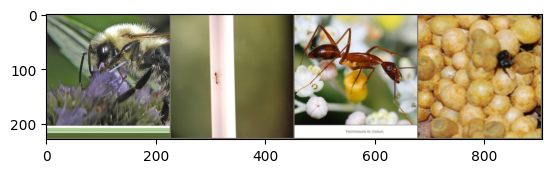

Classes:
bees ants ants bees


In [7]:
# show and review some images

# function to show an input image
def imshow(img, mean, std):
    """
    This function shows the actual image given the input pixel data

    Inputs:
        img: torch tensor
    """

    # convert to numpy and transpose
    npimg = img.numpy().transpose((1, 2, 0))

    # de-normalize
    npimg = npimg * std + mean
    npimg = np.clip(npimg, 0, 1)

    # show images
    plt.imshow(npimg)
    plt.show()
    
# get sample images
dataiter = iter(dataloaders["train"])
sample_inputs, sample_labels = next(dataiter)

# show images
sample_images = torchvision.utils.make_grid(sample_inputs)
imshow(sample_images, img_mean, img_std)
print("Classes:")
print(" ".join(classes[label] for label in sample_labels))

### Section 2: define training functions

In [8]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    """
    This function trains a given model on the train set, computes performance stats on both train and val, and saves the model with the best epoch level performances
    """

    since = time.time()

    with TemporaryDirectory() as tempdir:

        # save the model weights, and set it up for the saved weights to be updated 
        PATH = os.path.join(tempdir, "best_model_params.pt")
        torch.save(model.state_dict(), PATH)
        best_accuracy = 0.0

        # loop through epochs
        for epoch in range(num_epochs):

            print("Epoch: {epoch}/{num_epochs}".format(epoch=epoch, num_epochs=num_epochs-1))
            print("=" * 10)

            # each epoch has a train and a val phase
            for phase in ["train", "val"]:

                # initialize the model mode accordingly
                # learning - Some models use modules which have different training and evaluation behavior, 
                # such as batch normalization. To switch between these modes, use model.train() or model.eval() as appropriate
                # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
                model.train() if phase == "train" else model.eval()

                # initialize performance stats
                running_loss = 0.0
                running_corrects = 0

                # loop through the dataset
                for inputs, labels in dataloaders[phase]:

                    # move data to the proper device
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward prop
                    # perform gradient related tasks only if in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, predicts = torch.max(outputs, 1)

                        # backward prop and update weights only if in train
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # update performance stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicts==labels.data)

                # update the scheduler
                if phase == "train":
                    scheduler.step()

                # aggregate the epoch level states
                epoch_loss = running_loss / len(datasets[phase])
                epoch_accuracy = running_corrects / len(datasets[phase])
                print("{phase} loss: {epoch_loss:.4f} accuracy: {epoch_accuracy:.4f}".format(phase=phase, epoch_loss=epoch_loss, epoch_accuracy=epoch_accuracy))

                # update saved model weights if needed
                if phase=="val" and epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    torch.save(model.state_dict(), PATH)

            print()
            
        # print training stats
        time_elapsed = time.time() - since
        print("Training completed in {min:.0f}m {sec:.0f}s".format(min=(time_elapsed//60), sec=(time_elapsed%60)))
        print("Best val accuracy: {accuracy:.4f}".format(accuracy=best_accuracy))
        print()
        
        # load the best model
        model.load_state_dict(torch.load(PATH))
        
    return model

### Step 3: finetune a ResNet18 model

In [9]:
# get a pre-trained ResNet18 model 
model_ft = torchvision.models.resnet18(weights="IMAGENET1K_V1")

In [10]:
# replace the last layer of the original resnet18, also the only fc layer, by a new fc layer with the right number of output classes
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, len(classes))

In [11]:
# move the model to the right device
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# set the criterion/loss function for finetuning
criterion = nn.CrossEntropyLoss()

# set the optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
# train/finetune the model
model_ft = train_model(model=model_ft,
                       dataloaders=dataloaders,
                       criterion=criterion,
                       optimizer=optimizer_ft,
                       scheduler=exp_lr_scheduler,
                       num_epochs=25)

Epoch: 0/24
train loss: 0.4966 accuracy: 0.7459
val loss: 0.2063 accuracy: 0.9542

Epoch: 1/24
train loss: 0.6332 accuracy: 0.7787
val loss: 0.3831 accuracy: 0.8497

Epoch: 2/24
train loss: 0.7091 accuracy: 0.7582
val loss: 0.2981 accuracy: 0.8954

Epoch: 3/24
train loss: 0.7353 accuracy: 0.7500
val loss: 0.2153 accuracy: 0.9281

Epoch: 4/24
train loss: 0.4470 accuracy: 0.8402
val loss: 0.6016 accuracy: 0.7908

Epoch: 5/24
train loss: 0.8623 accuracy: 0.7787
val loss: 0.5318 accuracy: 0.8824

Epoch: 6/24
train loss: 0.7327 accuracy: 0.7951
val loss: 0.4098 accuracy: 0.8301

Epoch: 7/24
train loss: 0.3203 accuracy: 0.8770
val loss: 0.3847 accuracy: 0.8431

Epoch: 8/24
train loss: 0.3584 accuracy: 0.8402
val loss: 0.3610 accuracy: 0.8627

Epoch: 9/24
train loss: 0.3353 accuracy: 0.8402
val loss: 0.3166 accuracy: 0.8824

Epoch: 10/24
train loss: 0.3440 accuracy: 0.8402
val loss: 0.3551 accuracy: 0.8824

Epoch: 11/24
train loss: 0.3903 accuracy: 0.8361
val loss: 0.3487 accuracy: 0.8889

Ep

### Step 4: finetune only the last layer of a ResNet18 model

In [14]:
# set a new model with pretrained ResNet18 model weights
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")

In [15]:
# freeze all pretrained model weights
for param in model_conv.parameters():
    param.requires_grad = False

In [16]:
# replace the only fc layer with a new fc layer that has the right number of output classes for finetuning;
# parameters on the new fc layer has requires_grad = True by default
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, len(classes))

In [17]:
# move model to the right device
model_conv.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# set the loss function to be cross entropy loss
criterion = nn.CrossEntropyLoss()

In [19]:
# set the optimizer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [20]:
# decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
# run finetuning/training
model_conv = train_model(
    model=model_conv,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_conv,
    scheduler=exp_lr_scheduler,
    num_epochs=25
)

Epoch: 0/24
train loss: 0.5368 accuracy: 0.6721
val loss: 0.3173 accuracy: 0.8758

Epoch: 1/24
train loss: 0.4377 accuracy: 0.7746
val loss: 0.3444 accuracy: 0.8235

Epoch: 2/24
train loss: 0.4496 accuracy: 0.8197
val loss: 0.2128 accuracy: 0.9216

Epoch: 3/24
train loss: 0.5340 accuracy: 0.7910
val loss: 0.1775 accuracy: 0.9542

Epoch: 4/24
train loss: 0.4419 accuracy: 0.8115
val loss: 0.5315 accuracy: 0.7908

Epoch: 5/24
train loss: 0.5927 accuracy: 0.7459
val loss: 0.1763 accuracy: 0.9477

Epoch: 6/24
train loss: 0.5893 accuracy: 0.7828
val loss: 0.1918 accuracy: 0.9412

Epoch: 7/24
train loss: 0.3257 accuracy: 0.8607
val loss: 0.1775 accuracy: 0.9412

Epoch: 8/24
train loss: 0.2900 accuracy: 0.8648
val loss: 0.1816 accuracy: 0.9412

Epoch: 9/24
train loss: 0.4354 accuracy: 0.8033
val loss: 0.1886 accuracy: 0.9412

Epoch: 10/24
train loss: 0.3332 accuracy: 0.8730
val loss: 0.1850 accuracy: 0.9412

Epoch: 11/24
train loss: 0.3517 accuracy: 0.8566
val loss: 0.1957 accuracy: 0.9412

Ep

### Step 5: model inference on custom images 

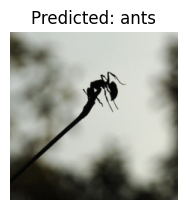

In [73]:
def visualize_predictions(model, img_path):
    """
    This function visualizes model predictions for any custom input image, given an input model
    """

    # save the training state of the input model, and then set the training state to eval
    was_training = model.training
    model.eval()

    # load and preprocess the input image
    img = Image.open(img_path)
    img = transform["val"](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    # forward pass to calculate the prediction
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
    
    # set up the plot
    ax = plt.subplot(2, 2, 1)
    ax.axis("off")
    ax.set_title("Predicted: {}".format(classes[predicted]))
    imshow(img.cpu().data[0], img_mean, img_std)

    # restore the training state of the input model
    model.train(mode=was_training)


# visualization of an example
visualize_predictions(model=model_conv, img_path="./hymenoptera_data/val/ants/94999827_36895faade.jpg")